In [2]:
from src import *

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

In [3]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

## Table of Contents
- [Stability](#stable)
    - Stability

In [6]:
mri_path = "./data/fmri400_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[14]
mri_df       = pd.read_csv(mri_path + movie_name)

film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(WASH + ONSET) + 1

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']


#### Generate gradients from subsets of subjects per movie

In [56]:
nb_per_sample = 25
subjects      = [c for c in mri_df.filename.unique() if '400' in c]
samples_names = []
samples_grad  = []
nbs = 10
for _ in range(nbs):
    samples_names.append(np.random.choice(subjects, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

# save('./resources/sample_grad/'+movie_name.split('_')[0] + '_samples.pkl', samples_grad)

100%|██████████| 10/10 [02:13<00:00, 13.34s/it]


#### Visualize Variance across Sampled Gradients for each Movies

In [7]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_grad/'):
    samples_grad.append(load('./resources/sample_grad/'+sample))
    samples_label.append(sample.split('_')[0])

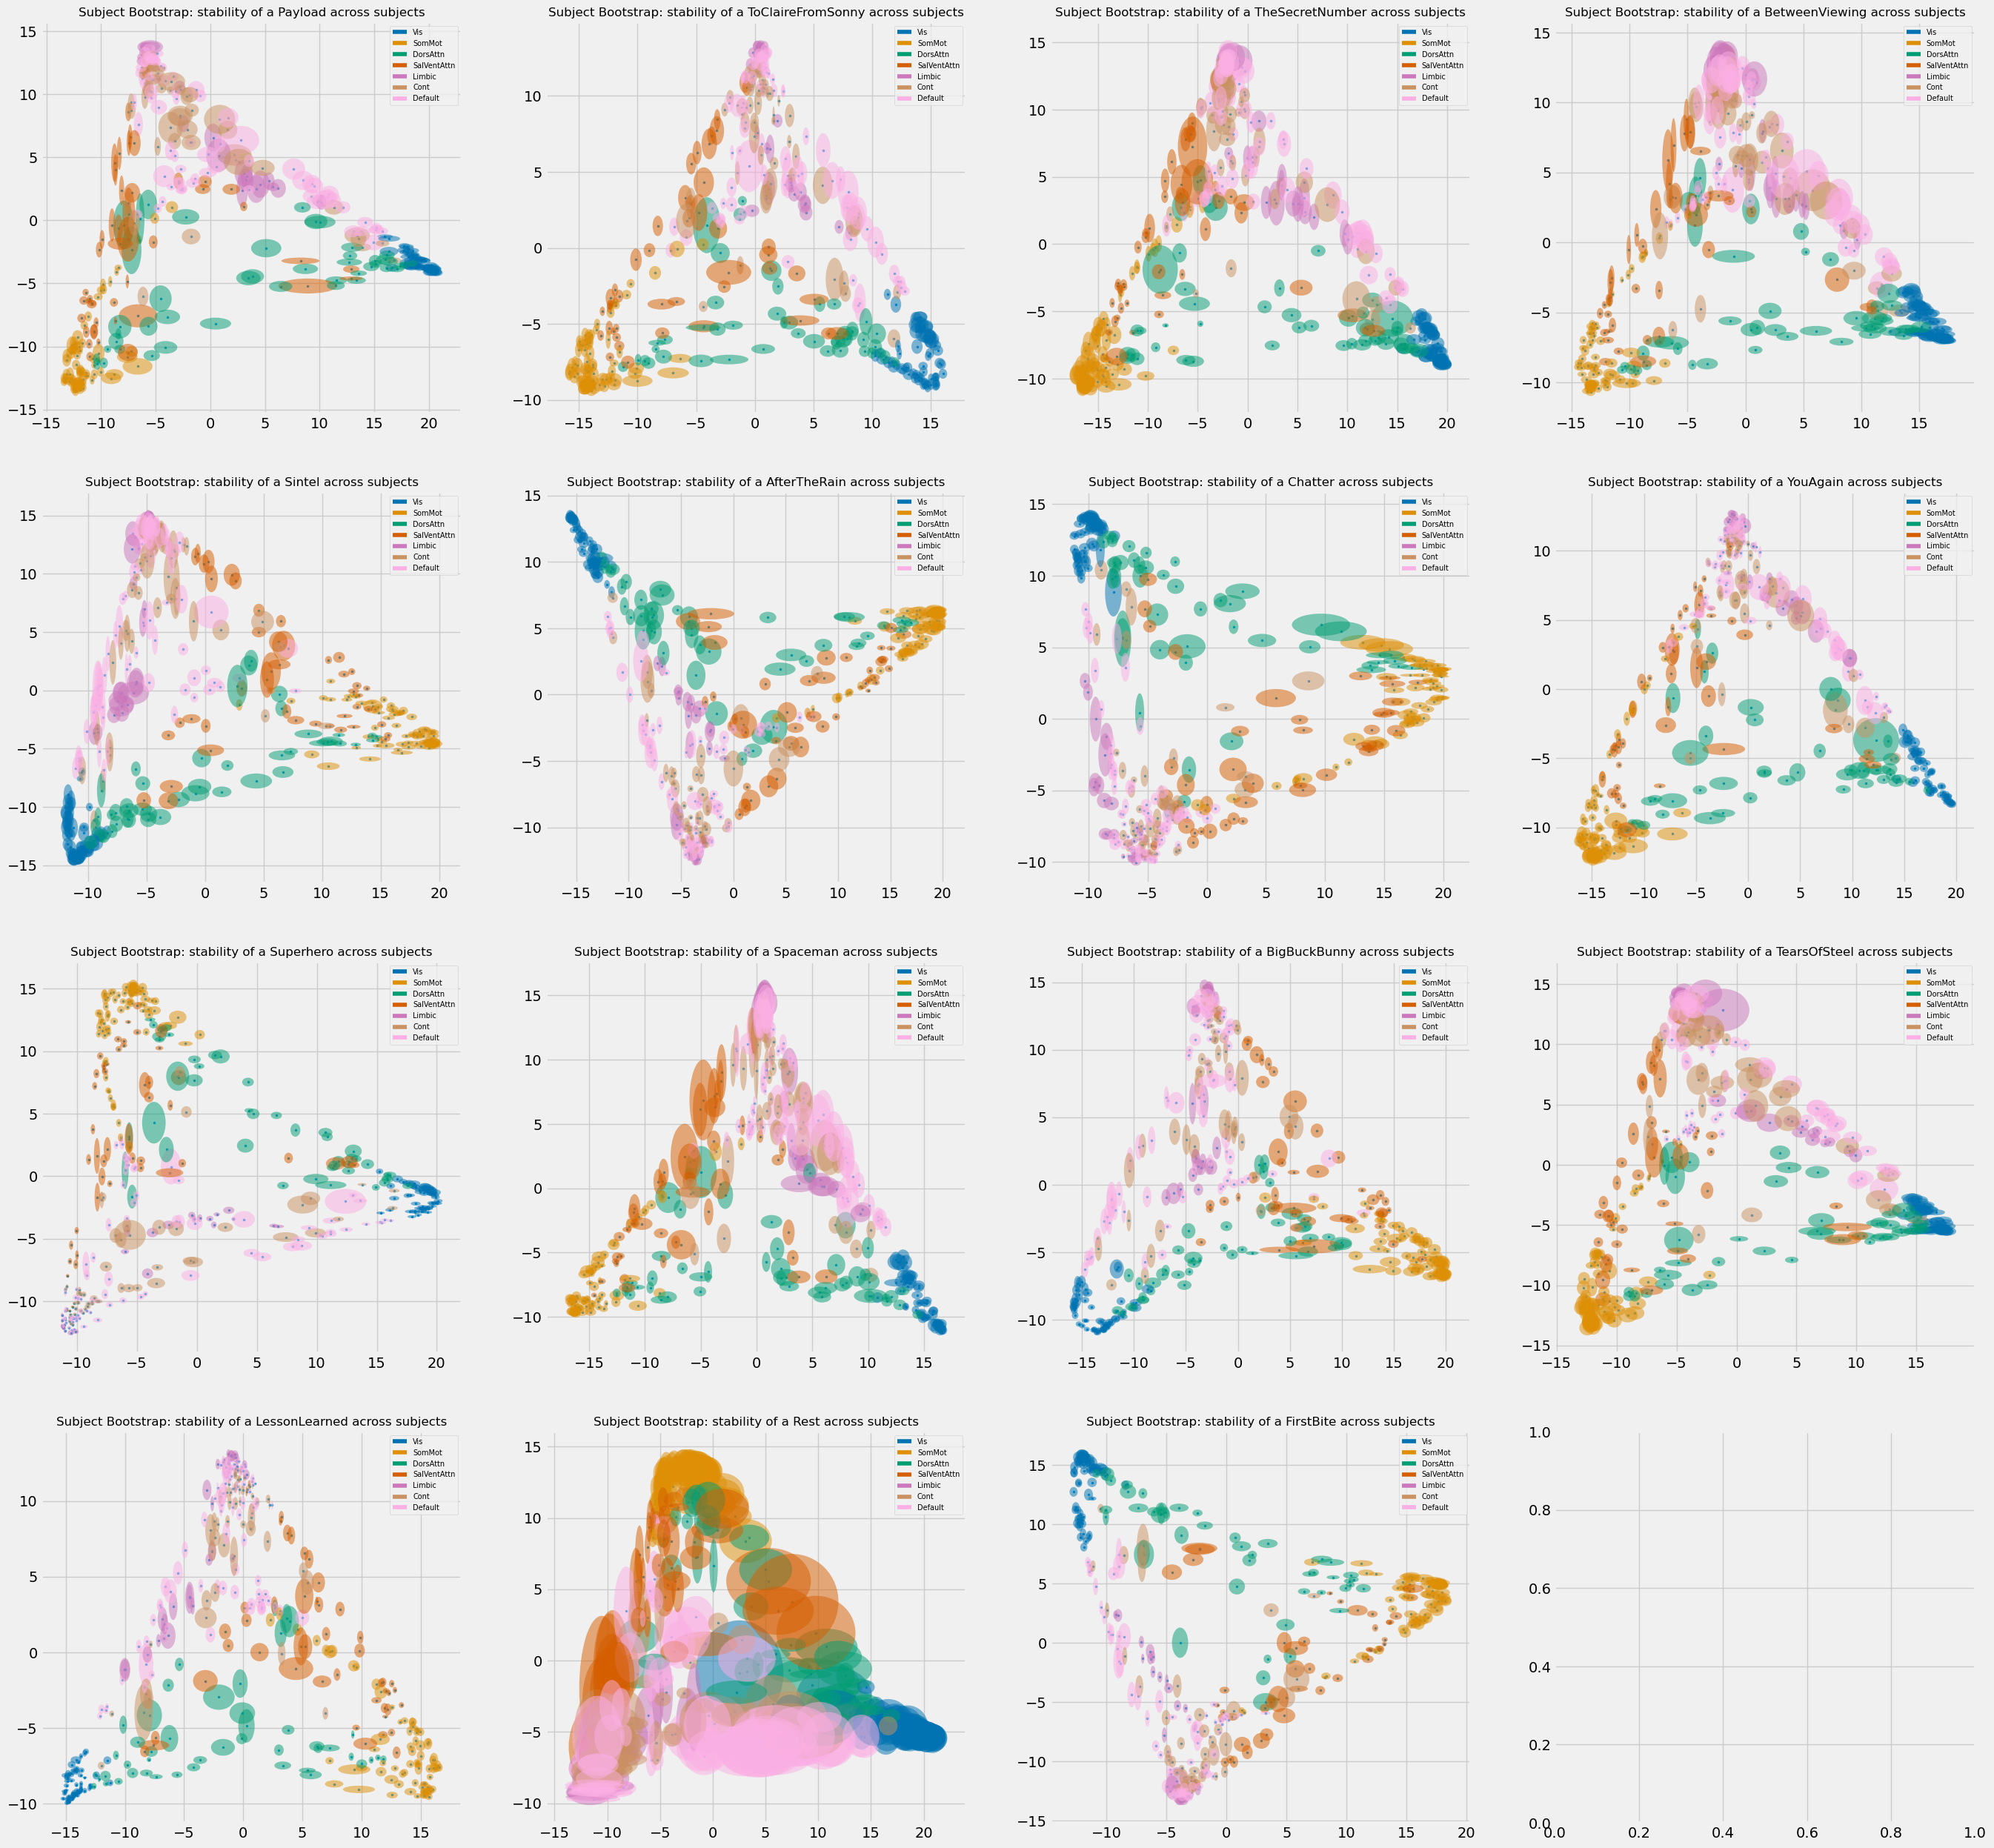

In [13]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}
# colors         = {'Vis': my_cmap.colors[idx], 'Default':'tab:orange', 'Cont':'tab:green', 'DorsAttn':'tab:red', 'Limbic':'tab:purple', 'SalVentAttn': 'tab:brown', 'SomMot': 'tab:pink'}


fig, axes = plt.subplots(4,4, figsize=(30,30))
aligned_samples = []
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    aligned,ref      = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    axes[row,col].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.5)

        # axes[row,col].add_artist(cc)
        axes[row,col].add_patch(ellipse)

    axes[row,col].set_title("Subject Bootstrap: stability of a {} across subjects".format(samples_label[k]), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})

plt.show()

#### Visualize Aggregated variance for each Movies 

(0.0, 4.0)

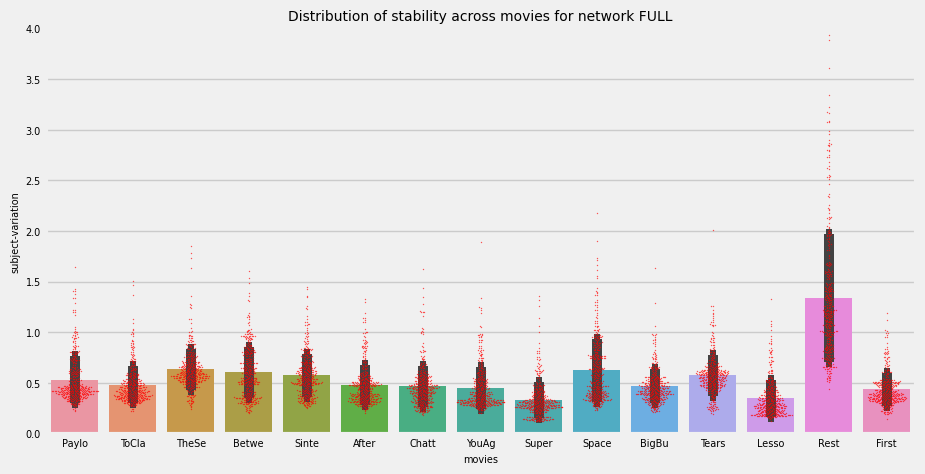

In [14]:
# Close-up view of a full network variation across subjects
fig, ax = plt.subplots(1,1, figsize=(10,5))
distrib = np.asarray(aligned_samples).std(axis=1)[...,[0,1]].mean(axis=-1)
concat_sample_labels  = []
for i in range(len(distrib)):
    concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

sns.barplot(ax=ax, x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(ax=ax, x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
ax.tick_params(labelsize=7)
ax.set_xlabel('movies', fontsize=7)
ax.set_ylabel('subject-variation', fontsize=7)
ax.set_title("Distribution of stability across movies for network {}".format('FULL'), size=10)
ax.set_ylim(0,4)

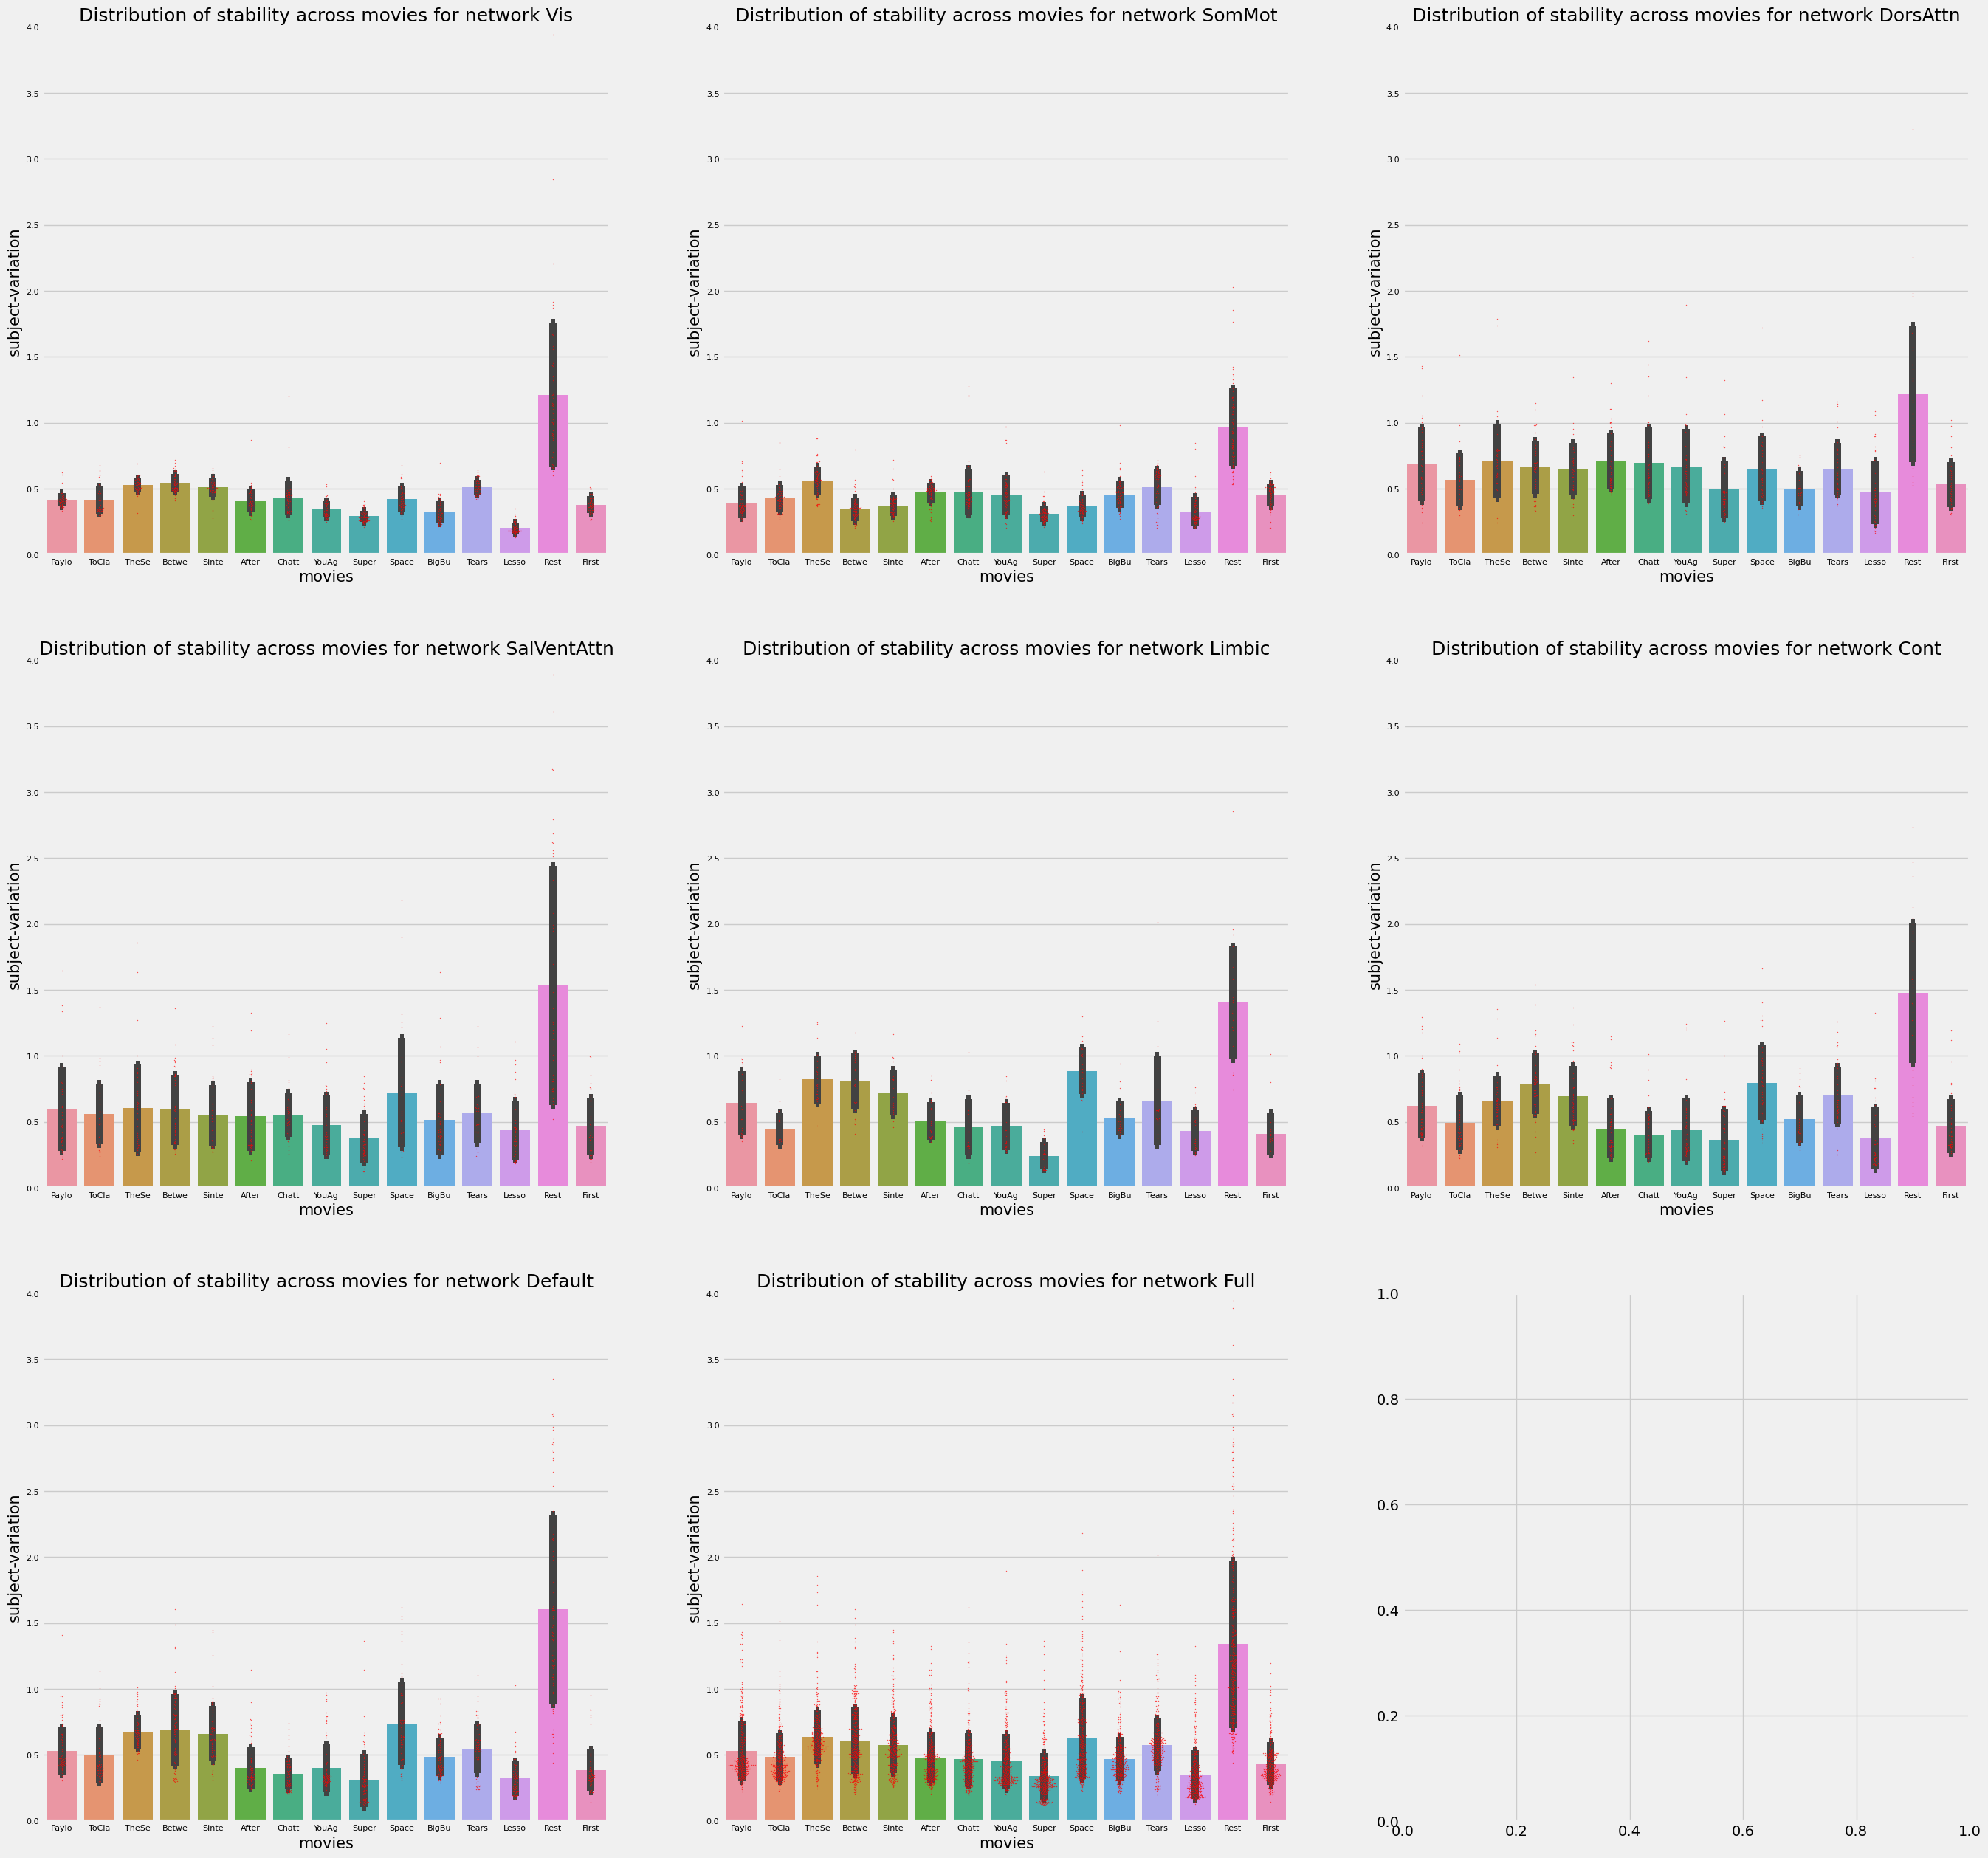

In [15]:
# ALL views of networks variation across subjects
partial_region = load('./resources/yeo7region400.pkl')
fig, ax = plt.subplots(3,3, figsize=(30,30))

for idx,r in enumerate(partial_region):
    row, col = idx//3, idx%3
    distrib = np.asarray(aligned_samples)[:,:,partial_region[r]].std(axis=1)[...,[0,1]].mean(axis=-1)
    concat_sample_labels  = []
    for i in range(len(distrib)):
        concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

    corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

    sns.barplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
    sns.swarmplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
    ax[row,col].tick_params(labelsize=8)
    ax[row,col].set_xlabel('movies', fontsize=15)
    ax[row,col].set_ylabel('subject-variation', fontsize=15)
    ax[row,col].set_title("Distribution of stability across movies for network {}".format(r), size=18)
    ax[row,col].set_ylim(0,4)

idx += 1
row, col = idx//3, idx%3
distrib = np.asarray(aligned_samples).std(axis=1)[...,[0,1]].mean(axis=-1)
concat_sample_labels  = []
for i in range(len(distrib)):
    concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

sns.barplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
ax[row,col].tick_params(labelsize=8)
ax[row,col].set_xlabel('movies', fontsize=15)
ax[row,col].set_ylabel('subject-variation', fontsize=15)
ax[row,col].set_title("Distribution of stability across movies for network {}".format('Full'), size=18)
ax[row,col].set_ylim(0,4)

plt.show()